In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from math import floor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
data = pd.read_csv("HeartDisease.csv")
data.drop(["Place", "ID"], axis=1, inplace=True )
data.head()

,Age,Sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,0


In [26]:
np.random.seed(1)
data_witout_na = data.dropna()
data_witout_na = data_witout_na.drop(['chol', 'restecg'], axis=1)
train, validate, test = np.split(data_witout_na.sample(frac=1), [int(.6*len(data_witout_na)), int(.8*len(data_witout_na))])

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score as f1
from sklearn.metrics import classification_report


rf = RandomForestClassifier()
rf.fit(train.drop(['num'], axis=1), train['num'])
preds = rf.predict(validate.drop(['num'], axis=1))

print("f1 validation ", f1(y_pred=preds, y_true=validate['num']))

test_preds = rf.predict(test.drop(['num'], axis=1))
print("classification report ", classification_report(y_pred=test_preds, y_true=test['num']))

f1 validation  0.6296296296296295
classification report                precision    recall  f1-score   support

           0       0.77      0.92      0.84        39
           1       0.86      0.63      0.73        30

   micro avg       0.80      0.80      0.80        69
   macro avg       0.81      0.78      0.78        69
weighted avg       0.81      0.80      0.79        69



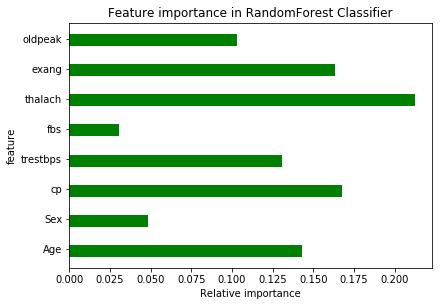

<Figure size 360x360 with 0 Axes>

In [35]:
col = list(data_witout_na.columns)
col.remove('num')
#modelname.feature_importance_
y = rf.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [38]:
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in rf.estimators_:
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=col,
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1

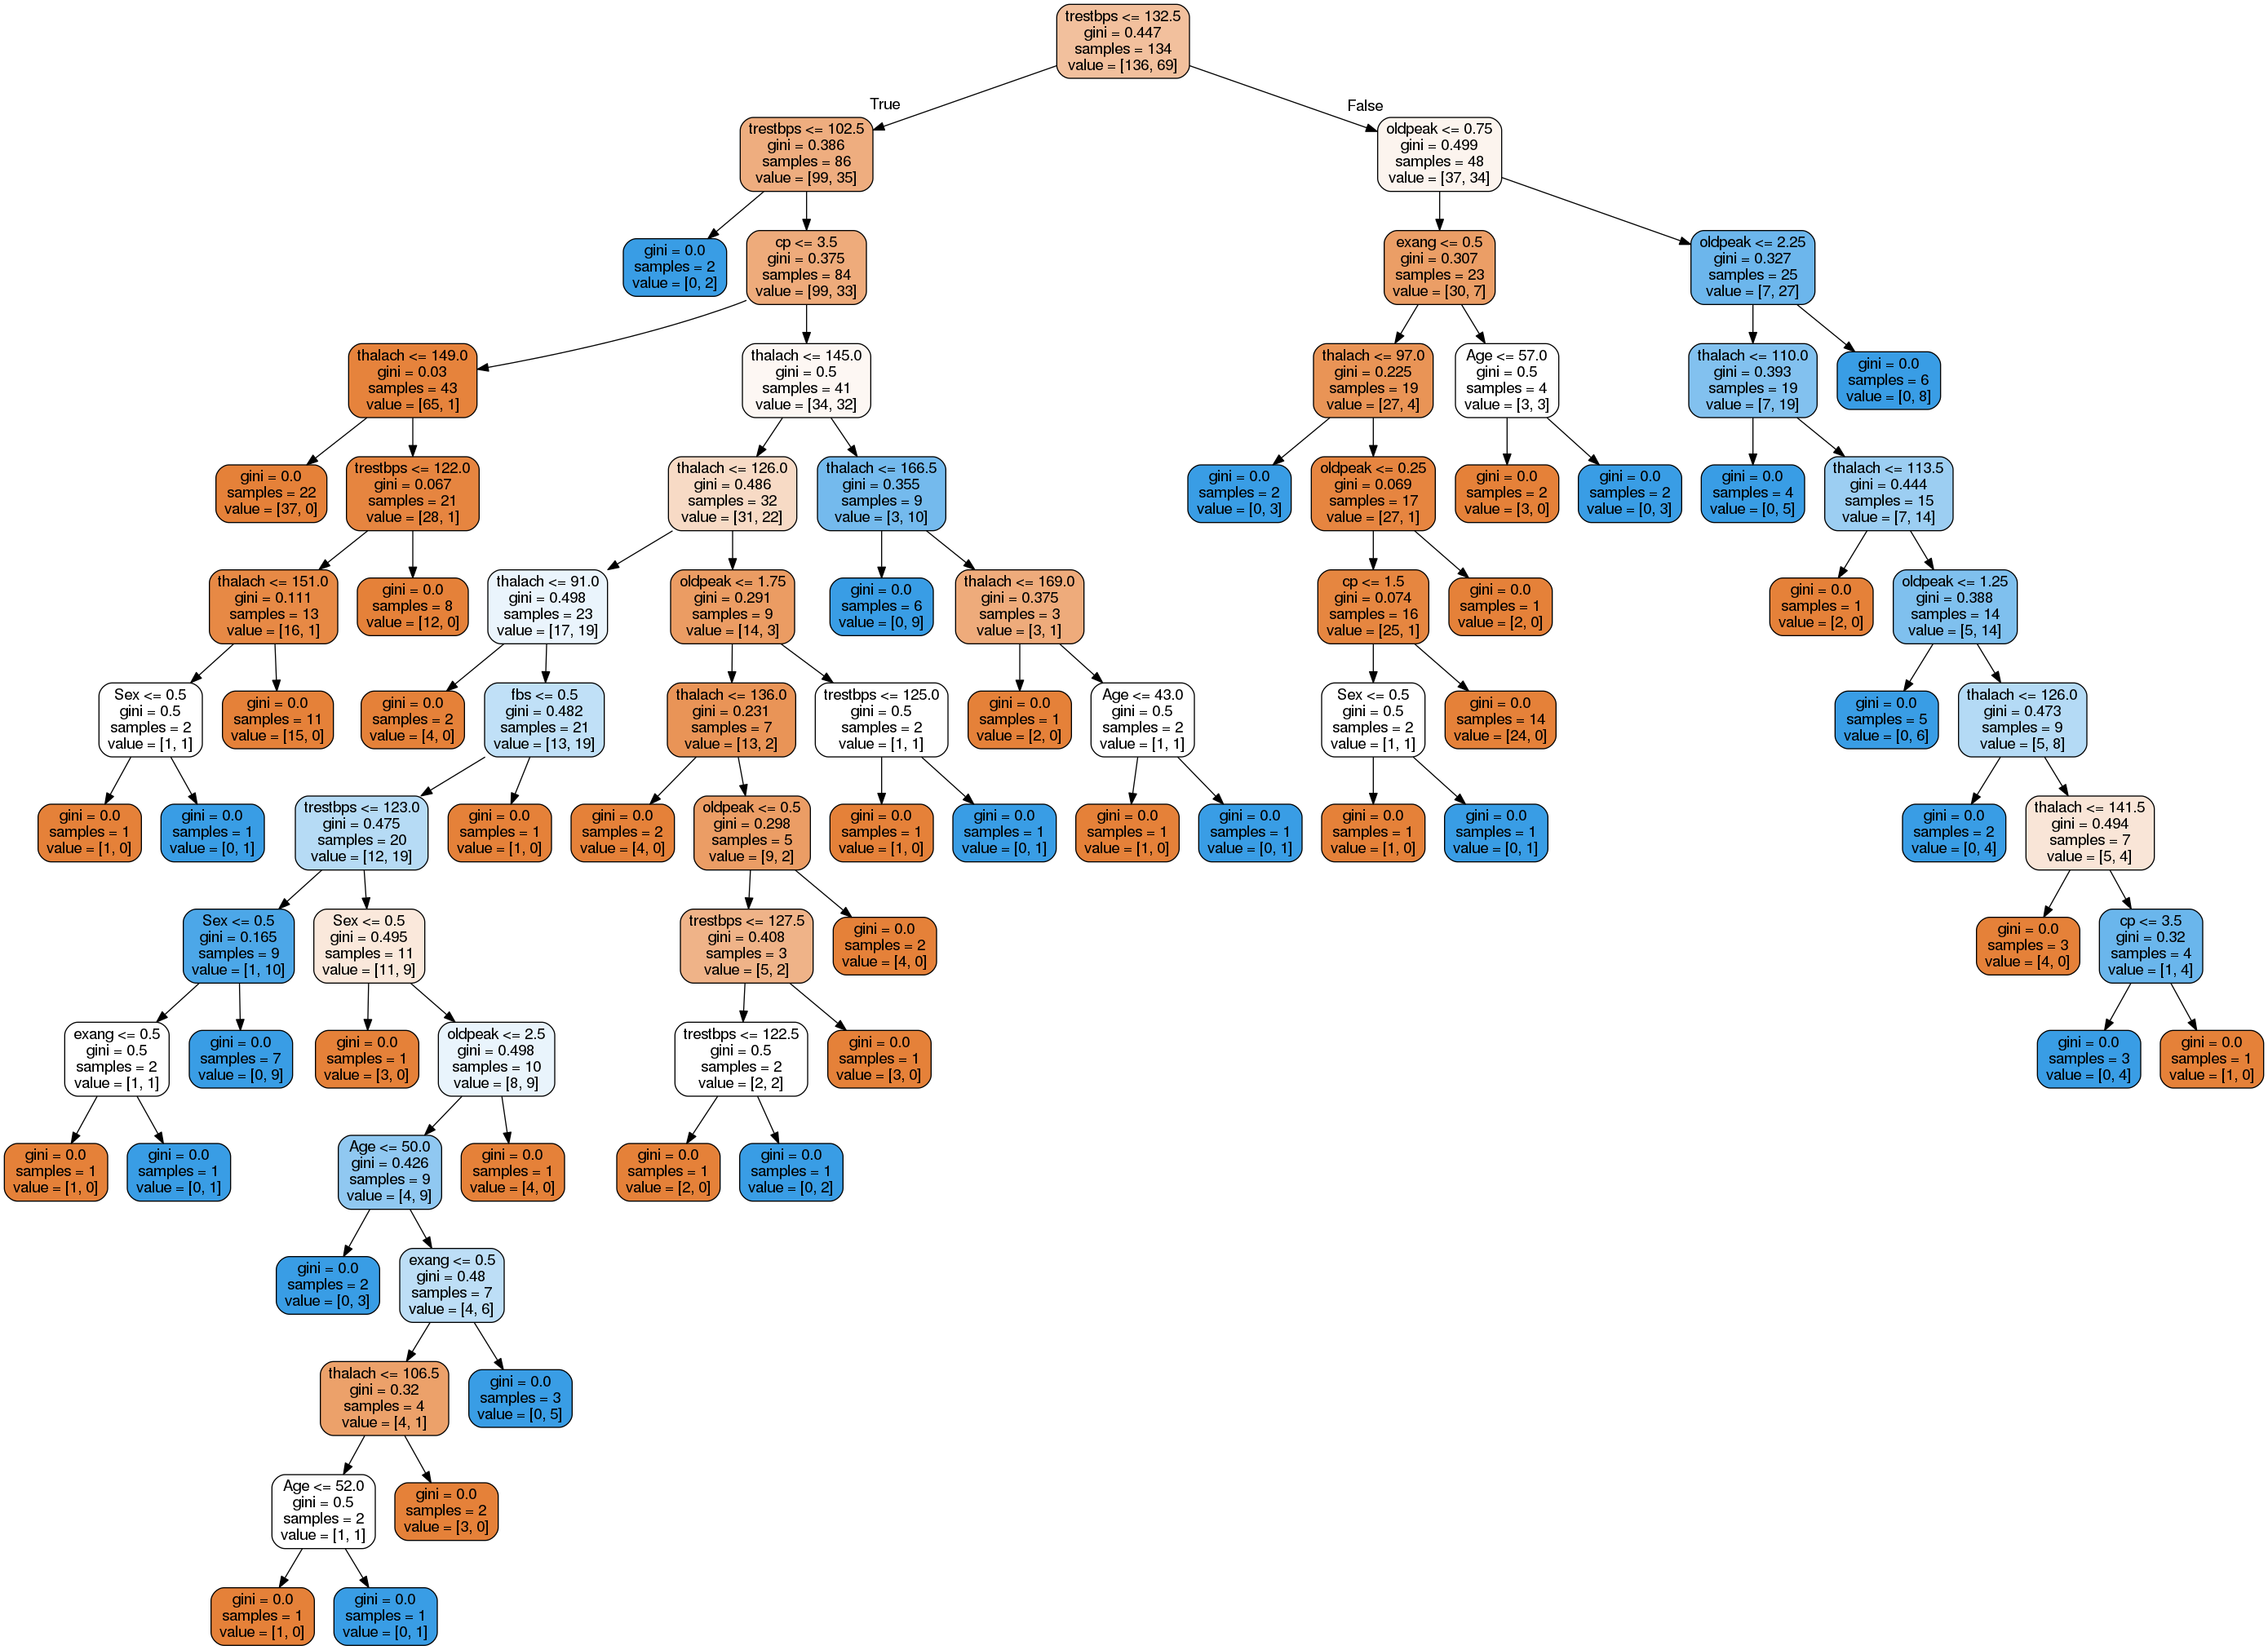

In [100]:
from IPython.display import Image
Image(filename = 'tree.png')

In [68]:
from lime.lime_tabular import LimeTabularExplainer


print(train.columns)
print(train.values.shape)
explainer = LimeTabularExplainer(
    train.drop('num', axis=1).values,
    feature_names = col,
    class_names=[0, 1]
)

explained = explainer.explain_instance(
    test.drop('num', axis=1).iloc[0, :], rf.predict_proba, num_features=8
)
explained.show_in_notebook()

Index(['Age', 'Sex', 'cp', 'trestbps', 'fbs', 'thalach', 'exang', 'oldpeak',
       'num'],
      dtype='object')
(205, 9)


In [71]:
# import tree_explainer
# tree_explainer.predict_explain(rf, test.drop('num')).assign(
#     TRUE_CLASS = tes['num']
# ).sort_values('SCORE', ascending = False).head(20)

In [89]:
from treeinterpreter import treeinterpreter as ti

print(test.drop('num', axis=1).iloc[0:10,:])
instances = test.drop('num', axis=1).iloc[0:10,:]

prediction, biases, contributions = ti.predict(rf, instances)

for i in range(len(instances)):
    print("Instance", i)
    print("Bias (trainset mean)", biases[i])
    print("Feature contributions:")
    for c, feature in zip(contributions[i], col):
        print(feature, c)
    print("-"*20) 


     Age  Sex  cp  trestbps  fbs  thalach  exang  oldpeak
217   54    1   4     125.0  0.0    122.0    0.0      2.0
83    46    1   4     110.0  0.0    140.0    0.0      0.0
274   58    1   2     136.0  0.0     99.0    1.0      2.0
100   48    1   3     110.0  0.0    138.0    0.0      0.0
270   55    1   4     145.0  0.0     96.0    1.0      2.0
165   55    1   4     140.0  0.0    110.0    1.0      0.5
362   46    1   4     110.0  0.0    125.0    1.0      2.0
318   56    1   3     120.0  0.0     97.0    0.0      0.0
158   55    0   2     130.0  0.0    150.0    0.0      0.0
191   35    1   2     110.0  0.0    140.0    0.0      0.0
Instance 0
Bias (trainset mean) [0.58243902 0.41756098]
Feature contributions:
Age [-0.00517446  0.00517446]
Sex [-0.06238756  0.06238756]
cp [-0.1058376  0.1058376]
trestbps [ 0.03850237 -0.03850237]
fbs [ 0.04058273 -0.04058273]
thalach [ 0.04682846 -0.04682846]
exang [ 0.18297404 -0.18297404]
oldpeak [-0.31792702  0.31792702]
--------------------
Instance 1

In [102]:
# import shap

In [117]:
from sklearn import metrics

def score(x1,x2):
    return metrics.mean_squared_error(x1,x2)
# defining feature importance function based on above logic
def feat_imp(m, x, y, small_good = True):
    score_list = {} 
    score_list['original'] = score(m.predict(x.values), y) 
    imp = {}
    for i in range(len(x.columns)): 
        rand_idx = np.random.permutation(len(x)) # randomization
        new_coli = x.values[rand_idx, i] 
        new_x = x.copy()            
        new_x[x.columns[i]] = new_coli 
        score_list[x.columns[i]] = score(m.predict(new_x.values), y) 
        imp[x.columns[i]] = score_list['original'] - score_list[x.columns[i]] # comparison with benchmark
        if small_good: 
            return sorted(imp.items(), key=lambda x: x[1]) 
        else: 
            return sorted(imp.items(), key=lambda x: x[1], reverse=True)
        
importance = feat_imp(rf, train[col], train['num'])
importance

[('Age', -0.058536585365853655)]